# NetVLAD Exploring

In [1]:
# Check if We have NVIDIA Driver Initialized 
!nvidia-smi

Failed to initialize NVML: Unknown Error


In [2]:
# Import Stuffs
import numpy as np 
import PIL
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchinfo
from torch.autograd import Variable
from torchvision.models import resnet18


import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

In [3]:
# Manual Seed
torch.manual_seed(777)

---

## NetVLAD Modules

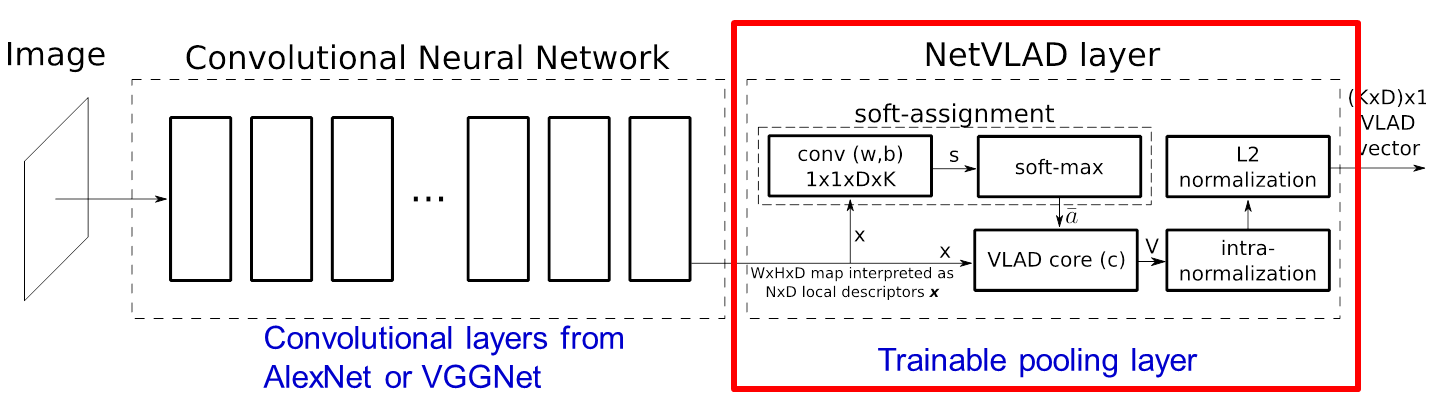

In [4]:
class NetVLAD(nn.Module):
    """
    NetVLAD Implementation
    """
    def __init__(self, 
            num_clusters=6,
            desc_dim=128,
            alpha=100.0,
            normalize_input=True,):
        # Initialize the Module
        super(NetVLAD, self).__init__()
        # Parameters
        self.num_clusters = num_clusters
        self.dim = desc_dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.DEBUG = False
        # Layers
        # Latent Convolution (add weight and bias to every latent)
        self.conv = nn.Conv2d(
            self.dim, 
            self.num_clusters, 
            kernel_size=(1, 1), 
            bias=True
        )
        # Where are those Centroids ?
        self.centroids = nn.Parameter(
            torch.rand(self.num_clusters, self.dim)
        )

        # Initialize Param
        self._init_params()
        
        # Prompt
        self.show_config()
    
    def show_config(self):
        """
        Show the Module settings
        """
        print("===========================================")
        print("NetVLAD Module initialized !")
        print("===========================================")        
        print(" - self.num_clusters : {}".format(self.num_clusters))
        print(" - self.dim : {}".format(self.dim))
        print(" - self.alpha : {}".format(self.alpha))
        print(" - self.normalize_input : {}".format(self.normalize_input))
        print("===========================================")
        
    def _init_params(self):
        """
        Initialize Parameters for Conv and Centroid
        """
        # Convolution Initialize Weight
        # Unsqueeze for Extend the dimension from ( K cluster, D-feature dimension ) = (K x D)
        # to (K x D x 1 x 1)
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        # Convolution Initialize Bias 
        self.conv.bias = nn.Parameter(
            -self.alpha * self.centroids.norm(dim=1)
        )
    
    def forward(self, x):
        """
        Forward Passing for NetVLAD Layer 
        input x -> Local Feature Description
        W*H*D map interpreted as NxD Local Descriptor "x"
        """
        # Store the Shape of first 2 dim (batch size, channels)
        BATCH_SIZE, CHANNEL = x.shape[0:2]
        # Decide to Normalize or not ?
        if self.normalize_input:
            # Normalize Across Descriptor Dim (across vector's components)
            x = F.normalize(x, p=2, dim=1)
        
        ################################################
        # Soft Assignment (A)
        ################################################
        soft_assignment = self.conv(x) # WkXi + Bk (output_shape = (cluster,W,H))
        # Readjust the shape to (N rows x K cluster x any)
        soft_assignment = soft_assignment.view(BATCH_SIZE, self.num_clusters, -1) # (Cluster x w*h)
        # Create result from group assignment -> a(x) (dim 1 mean in the row vec)
        soft_assignment = F.softmax(soft_assignment, dim=1)
        
        ################################################
        # Create VLAD Core
        ################################################
        # Create Flatten X (X which is directly comes from feature encoder)
        x_flatten = x.view(BATCH_SIZE, CHANNEL, -1) # (N x FeatureDim x (w*h))
        
        # Calculate Residual
        if self.DEBUG:print("X Before Expand : {}".format(x_flatten.shape))
        x_flatten_adjusted = x_flatten.expand(self.num_clusters, -1, -1, -1)
        if self.DEBUG:print("X After Expand : {}".format(x_flatten_adjusted.shape))
        x_flatten_adjusted = x_flatten_adjusted.permute(1,0,2,3)
        if self.DEBUG:print("X After Permute : {}".format(x_flatten_adjusted.shape))
        
        # Now X_Flatten_Adjusted Shape = ( torch.Size([1, 6, 128, 16]) )
        # = torch.Size([1, CLUSTER_SIZE , FEATURE_SIZE , (WxH) ])
        if self.DEBUG:print("---")
        
        if self.DEBUG:print("Centroid Before Expand : {}".format(self.centroids.shape))
        centroid_adjusted = self.centroids.expand(x_flatten.size(-1), -1, -1) # (w*h,-1,-1)
        if self.DEBUG:print("Centroid After Expand : {}".format(centroid_adjusted.shape))
        
        centroid_adjusted = centroid_adjusted.permute(1,2,0)
        if self.DEBUG:print("Centroid After Permute : {}".format(centroid_adjusted.shape))
        
        centroid_adjusted = centroid_adjusted.unsqueeze(0)
        if self.DEBUG:print("Centroid After Unsqueeze : {}".format(centroid_adjusted.shape))
        
        
        residual = x_flatten_adjusted - centroid_adjusted
        
        # Calculate Summation
        vlad = residual * soft_assignment.unsqueeze(2)
        vlad = vlad.sum(dim=-1)
        # Intra-Normalization
        vlad = F.normalize(vlad, p=2, dim=2) 
        vlad = vlad.view(x.size(0), -1)  # flatten
        
        # L2 normalize
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize
        if self.DEBUG:print("VLAD Shape : {}".format(vlad.shape))
        
        return vlad

In [5]:
torchinfo.summary(NetVLAD(), input_size=(1,128,4,4))

NetVLAD Module initialized !
 - self.num_clusters : 6
 - self.dim : 128
 - self.alpha : 100.0
 - self.normalize_input : True


/usr/local/lib/python3.8/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.8/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
NetVLAD                                  [1, 768]                  768
├─Conv2d: 1-1                            [1, 6, 4, 4]              774
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

---

## Feature Extraction Head / Base Model
3 Choices
- VGG16
- ResNet18
- RPS

In [6]:
# Feature Extraction 
from torchvision.models import resnet18
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

### VGG16

In [7]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        encoder = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(
            encoder.features
        )
        
        # Freeze
        for param in self.feature_extractor.parameters(): #NOTE: prune:True  // finetune:False
            param.requires_grad = False 
        
        last_dim_size = list(self.feature_extractor.parameters())[-1].shape[0]
        print("VGG16 Dim Size: {}".format(last_dim_size))
    
    def forward(self, x): 
        return self.feature_extractor(x)

In [8]:
torchinfo.summary(VGG16(), input_size=(1,3,256,256))

VGG16 Dim Size: 512


Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 512, 8, 8]            --
├─Sequential: 1-1                        [1, 512, 8, 8]            --
│    └─Sequential: 2-1                   [1, 512, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [1, 64, 256, 256]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [1, 128, 128, 128]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                  [1, 128, 128, 128]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 64, 64]    

### Resnet-18

In [9]:
# Feature Extraction Head Pretrained from ResNet18
class Resnet18(nn.Module): 
    def __init__(self):
        super(Resnet18, self).__init__()
        encoder = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(
            encoder.conv1,
            encoder.bn1,
            encoder.relu,
            encoder.maxpool,
            encoder.layer1,
            encoder.layer2,
            encoder.layer3,
            encoder.layer4,
        )
        # Freeze
        for param in self.feature_extractor.parameters(): #NOTE: prune:True  // finetune:False
            param.requires_grad = False 
            
        last_dim_size = list(self.feature_extractor.parameters())[-1].shape[0]
        print("ResNet18 Dim Size: {}".format(last_dim_size))
    
    def forward(self, x):
        result = self.feature_extractor(x)
        return result
    

In [10]:
torchinfo.summary(Resnet18(), input_size=(1,3,256,256))

ResNet18 Dim Size: 512


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
Resnet18                                      [1, 512, 8, 8]            --
├─Sequential: 1-1                             [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         (128)
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           (73,984)
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]      

## Main Model 

In [11]:
class VPRModel(nn.Module): 
    def __init__(self, feature_extractor, netvlad):
        super(VPRModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.netvlad = netvlad
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.netvlad(x)
        return x

### Create Main Model

In [12]:
model_resnet18 = Resnet18()
model_vgg16 = VGG16()

ResNet18 Dim Size: 512
VGG16 Dim Size: 512


In [13]:
# NetVLAD Config
netvlad_config = {
    "num_clusters": 6, 
    "desc_dim": 512, # Up to the Feature Extraction Module
    "alpha": 100.0,
    "normalize_input": True,
}
model_netvlad = NetVLAD(**netvlad_config)

NetVLAD Module initialized !
 - self.num_clusters : 6
 - self.dim : 512
 - self.alpha : 100.0
 - self.normalize_input : True


In [14]:
model = VPRModel(
    feature_extractor=model_resnet18,
    netvlad=model_netvlad,
)

In [15]:
torchinfo.summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                             Output Shape              Param #
VPRModel                                           [1, 3072]                 --
├─Resnet18: 1-1                                    [1, 512, 8, 8]            --
│    └─Sequential: 2-1                             [1, 512, 8, 8]            --
│    │    └─Conv2d: 3-1                            [1, 64, 128, 128]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 128, 128]         (128)
│    │    └─ReLU: 3-3                              [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [1, 64, 64, 64]           (147,968)
│    │    └─Sequential: 3-6                        [1, 128, 32, 32]          (525,568)
│    │    └─Sequential: 3-7                        [1, 256, 16, 16]          (2,099,712)
│    │    └─Sequential: 3-8                        [1, 512, 8, 8]            (8,393,

## Loss Function

### Pairwise Distances

In [31]:
def _pairwise_distance(x, squared=False, eps=1e-16):
    """
    Compute the 2D Matrix of distance between all the embeddings using
    Inner Product and Euclidean Dist Relation
     => (dist(X,Y)^2)/2 = 1 - InnerProduct(X,Y)
    """
    # Create Inner Product <X,Y> = <Embedding, Embeddings.T>
    # called Correlation Matrix
    cor_mat = torch.matmul(x, x.t())
    # Create Norm Matrix from correlation
    norm_mat = cor_mat.diag()
    # Create inner product <X,X>, <Y,Y>
    xx = norm_mat.unsqueeze(0)
    yy = norm_mat.unsqueeze(1)
    # Calculate DistanceSquared d^2 = <X,X> + <Y,Y> - 2<X,Y>
    distances = xx + yy - 2 * cor_mat
    # Filter Negative Dist 
    distances = F.relu(distances)

    # We need to take square root if squared is False
    # torch.sqrt issue with Backprop - need to add epsilon for derivative
    # https://discuss.pytorch.org/t/57373
    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances

### Data Searching

In [32]:
def _get_anchor_positive_triplet_mask(labels):
    """
    Given labels of size (batch_size, ) 
    Return a 2D Mask : Where mask[Anchor, Positive] is True
    iff Anchor and Positive 
    - Distinct 
    - Same Label
    
    Mask will omitted the self index (result 0)
    label [1,1,2,2,3,1] 
    for item idx 0 will return [X(zero),1,0,0,0,1]
    """
    # Device Select
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Negative Mask
    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    # Masked Self Index out to 0
    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (~i_equal_k)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

### Loss - Hard Triplet Loss

In [67]:
# Hard Triplet Loss
class HardTripletLoss(nn.Module):
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        # Parameter Mode Config
        self.margin  = margin
        self.hardest = hardest
        self.squared = squared
    
    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        print("Embeddings Size = {}".format(embeddings.shape))
        print("labels Size = {}".format(labels.shape))
        
        # Populate All Data - Pair Distances
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)
        
        # Switch Mode between hardest triplet loss or hard triplet loss
        if self.hardest:
            triplet_loss = self.hardest_triplet_loss(pairwise_dist, embeddings, labels)
            print("Hardest Loss Shape : {}".format(triplet_loss.shape))
            
        else:
            triplet_loss = self.hard_triplet_loss(pairwise_dist, embeddings, labels)
            print("Hard Loss Shape : {}".format(triplet_loss.shape))
            
        print("Loss Shape : {}".format(triplet_loss.shape))
        return triplet_loss
            
    def hardest_triplet_loss(self, pairwise_dist, embeddings, labels):
        """
        Hardest Triplet Loss
        - Get The Hardest Positive Pair (Biggest Distance = Very Loss)
        - Get The Hardest Negative Pair (Nearest Distance = Very Loss)
        - Calculate Distance between Those Hardest and our anchor
        - Loss = Relu(hardest_pos_dist - hardest_negative + margin?)
        """
        # Find the Hardest Positive Pair
        # - Get Same Class Mask
        mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
        valid_positive_dist = pairwise_dist * mask_anchor_positive
        # - Find the Hardest Positive distances (Farthest = Very Loss)
        hardest_positive_dist, _ = torch.max(
            valid_positive_dist, 
            dim=1, keepdim=True
        )
        print("Shape of Hardest Pos : {}".format(hardest_positive_dist.shape))
        
        # Find the Hardest Negative Pair
        # - Get Negative Class Mask
        mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
        max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
        anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
        hardest_negative_dist, _ = torch.min(
            anchor_negative_dist, 
            dim=1, keepdim=True
        )
        print("Shape of Hardest Neg : {}".format(hardest_negative_dist.shape))
        
        
        # Find the Loss
        # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
        triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + self.margin)
        print("Shape of Triplet Loss : {}".format(triplet_loss.shape))
        
        triplet_loss = torch.mean(triplet_loss)
        
        
        
        return triplet_loss
    
    def hard_triplet_loss(self, pairwise_dist, embeddings, labels):
        anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
        anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

        # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
        # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
        # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
        # and the 2nd (batch_size, 1, batch_size)
        loss = anc_pos_dist - anc_neg_dist + self.margin

        mask = _get_triplet_mask(labels).float()
        triplet_loss = loss * mask

        # Remove negative losses (i.e. the easy triplets)
        triplet_loss = F.relu(triplet_loss)

        # Count number of hard triplets (where triplet_loss > 0)
        hard_triplets = torch.gt(triplet_loss, 1e-16).float()
        num_hard_triplets = torch.sum(hard_triplets)

        triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)
        
        return triplet_loss


In [68]:
torchinfo.summary(HardTripletLoss(hardest=True), input_size=[(10,512), (10,)])

Embeddings Size = torch.Size([10, 512])
labels Size = torch.Size([10])
Shape of Hardest Pos : torch.Size([10, 1])
Shape of Hardest Neg : torch.Size([10, 1])
Shape of Triplet Loss : torch.Size([10, 1])
Hardest Loss Shape : torch.Size([])
Loss Shape : torch.Size([])


/usr/local/lib/python3.8/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.8/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
HardTripletLoss                          --                        --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

# Datasets

# NetVLAD Training